In [ ]:
'''
1. データのダウンロード
'''
import os
import tensorflow as tf

# データセットのダウンロード
# Kaggle の Dogs vs Cats データセットをフィルタリングしたバージョンを使用
# データセットのアーカイブバージョンをダウンロードし、"/tmp/"ディレクトリに保存
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# 訓練および検証データのファイルパスを変数に格納
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
'''
2. ジェネレーターを生成し、画像を加工処理する
''' 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

def ImageDataGenerate(train_dir, validation_dir):
    """画像を加工処理する
    
    Returns:
      train_generator(DirectoryIterator):
          加工処理後の訓練データ
      validation_generator(DirectoryIterator):
          加工処理後の検証データ
    """
    # データセットの前処理およびネットワークの学習中に使用する変数を設定
    batch_size = 32
    IMG_HEIGHT = 224
    IMG_WIDTH = 224

    # ジェネレーターの生成
    # 訓練データのジェネレーター
    train_image_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        width_shift_range=0.1,
        height_shift_range=0.1
        )
    # 検証データのジェネレーター
    validation_image_generator = ImageDataGenerator(rescale=1./255)

    # flow_from_directory()メソッドでディスクから画像を読み込み、
    # リスケーリングを適用して画像を必要な大きさにリサイズ
    # 訓練データ
    train_data_gen = train_image_generator.flow_from_directory(
        batch_size=batch_size, # ミニバッチのサイズ
        directory=train_dir,   # 抽出先のディレクトリ
        shuffle=True,          # 抽出する際にシャッフルする
        target_size=(IMG_HEIGHT, IMG_WIDTH), # 画像をリサイズ
        class_mode='binary')   # 正解ラベルを0と1に変換

    # 検証データ
    val_data_gen = validation_image_generator.flow_from_directory(
        batch_size=batch_size, # ミニバッチのサイズ
        directory=validation_dir,   # 抽出先のディレクトリ
        target_size=(IMG_HEIGHT, IMG_WIDTH), # 画像をリサイズ
        class_mode='binary')   # 正解ラベルを0と1に変換
    
    # 生成した訓練データと検証データを返す
    return train_data_gen, val_data_gen

In [ ]:
'''
3. モデルを生成して学習を行う
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def train_FClayer(train_data_gen, val_data_gen):
    """ファインチューニングしたVGG16で学習する
    
    Returns:
      history(Historyオブジェクト)
    """
    # 画像のサイズを取得
    image_size = len(train_data_gen[0][0][0])
    # 入力データの形状をタプルにする
    input_shape = (image_size, image_size, 3)
    # ミニバッチのサイズを取得
    batch_size = len(train_data_gen[0][0])
    # 訓練データの数を取得(バッチの数×ミニバッチサイズ)
    total_train = len(train_data_gen)*batch_size
    # 検証データの数を取得(バッチの数×ミニバッチサイズ)
    total_validate = len(val_data_gen)*batch_size

    # VGG16モデルを学習済みの重みと共に読み込む
    pre_trained_model = VGG16(
        include_top=False,            # 全結合層（FC）は読み込まない
        weights='imagenet',           # ImageNetで学習した重みを利用
        input_shape=input_shape   # 入力データの形状
    )

    for layer in pre_trained_model.layers[:15]:
        # 第1～第15層までの重みを凍結
        layer.trainable = False

    for layer in pre_trained_model.layers[15:]:
        # 第16層以降の重みを更新可能にする
        layer.trainable = True
    
    # Sequentualオブジェクトを生成
    model = Sequential()

    # VGG16モデルを追加
    model.add(pre_trained_model)

    # (batch_size, rows, cols, channels)の4階テンソルに
    # プーリング演算適用後、(batch_size, channels)の2階テンソルにフラット化
    model.add(
        GlobalMaxPooling2D())

    # 全結合層
    model.add(
        Dense(512,               # ユニット数512
              activation='relu') # 活性化関数はReLU
    )
    # 50%のドロップアウト
    model.add(Dropout(0.5))

    # 出力層
    model.add(
        Dense(1,                    # ユニット数1
              activation='sigmoid') # 活性化関数はSigmoid
    )
    
    # モデルのコンパイル
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-5),
                  metrics=['accuracy'])
    
    # コンパイル後のサマリを表示
    model.summary()

    # 学習率をスケジューリングする
    def step_decay(epoch):
        initial_lrate = 0.00001 # 学習率の初期値
        drop = 0.5              # 減衰率は50%
        epochs_drop = 10.0      # 10エポック毎に減衰する
        lrate = initial_lrate * math.pow(
            drop,
            math.floor((epoch)/epochs_drop)
        )
        return lrate

    # 学習率のコールバック
    lrate = LearningRateScheduler(step_decay)

    # ファインチューニングモデルで学習する
    epochs = 40   # エポック数
    history = model.fit(
        # 訓練データ
        train_data_gen,
        # エポック数
        epochs=epochs,
        # 検証データ
        validation_data=val_data_gen,
        # 検証時のステップ数
        validation_steps=total_validate//batch_size,
        # 訓練時のステップ数
        steps_per_epoch=total_train//batch_size,
        # 学習の進捗状況を出力する    
        verbose=1,
        # 学習率のスケジューラーをコール
        callbacks=[lrate]
    )
    
    # historyを返す
    return history

In [ ]:
%%time
'''
4. 学習を行う
'''
# ジェネレーターで加工する
train_data_gen, val_data_gen = ImageDataGenerate(train_dir, validation_dir)
# VGG16の出力をFCネットワークで学習
history = train_FClayer(train_data_gen, val_data_gen)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 7,342,593
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/40
63/63 [=

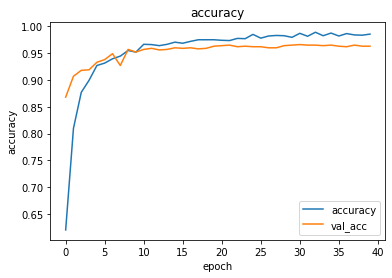

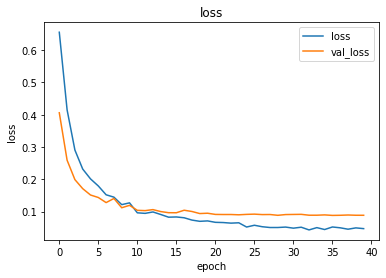

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # 精度の推移をプロット
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_acc")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の推移をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
    
# 損失と精度をグラフに出力
plot_acc_loss(history)